<a href="https://colab.research.google.com/github/DhakalSumi/Time-series-Project/blob/main/TimeSeriesForecast_Guayas_Project_Sumi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all libraries we will need


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter


# Connect to Goole Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the files with pandas

In [3]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

In [4]:
#Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Define the date range for Jan-March 2014
start_date = '2014-01-01'
end_date = '2014-03-31'

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['date'] >= start_date) &
        (chunk['date'] <= end_date)]

    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)


# Clean up to free memory
del filtered_chunks

print(df_train.shape)

<ipython-input-4-58e2e4d68e94>:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):


(996117, 6)


In [5]:
df_items.head(5)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [6]:
df_stores.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
df_train['store_nbr'].nunique(), df_stores['store_nbr'].nunique()

(10, 54)

In [8]:
df_train['item_nbr'].nunique(), df_items['item_nbr'].nunique()

(2630, 4100)

only fraction of items presented in the region “Guayas”

---



In [9]:
df_transactions.head(5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [10]:
df_oil.head(7)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08


In [11]:
df_holidays_events.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## Checking missing values

In [12]:
# Count missing values per column
missing_values = df_train.isna().sum()

# Print the result
print(missing_values)

id                  0
date                0
store_nbr           0
item_nbr            0
unit_sales          0
onpromotion    996117
dtype: int64


In [13]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

<ipython-input-13-7bdead4240c5>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


# Handling Outliers

## Negative sales

In [14]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
10834,16366453,2014-01-02,36,812769,-120.000,False
36271,16523001,2014-01-04,51,205209,-1.034,False
89111,16812790,2014-01-09,27,1464034,-2.000,False
94957,16820878,2014-01-09,36,1124165,-3.000,False
95598,16841624,2014-01-09,51,374464,-11.000,False


## Extremely high sales

In [15]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group


# Apply the Z-score calculation to each store-item group without resetting the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped = df_train_grouped.reset_index(drop=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 898


<ipython-input-15-47574a334bea>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
60,18886543,2014-02-13,24,103520,22.0,False,5.200925
271,21294315,2014-03-26,24,105574,40.0,False,5.544436
1593,17002942,2014-01-12,24,114800,95.0,False,6.915745
3070,20272198,2014-03-10,24,122095,18.0,False,5.956962
3835,18487433,2014-02-05,24,129758,31.0,False,5.516425


# Feature Engineering

In [16]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
print("Data range: from",df_train['date'].dt.date.min(),"till",df_train['date'].dt.date.max())

Data range: from 2014-01-01 till 2014-03-31


In [17]:
# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())
df_train['unit_sales_7d_avg']

,unit_sales_7d_avg
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
996112,33.797057
996113,17.642271
996114,1.142857
996115,3.714286


# Visualizing Data

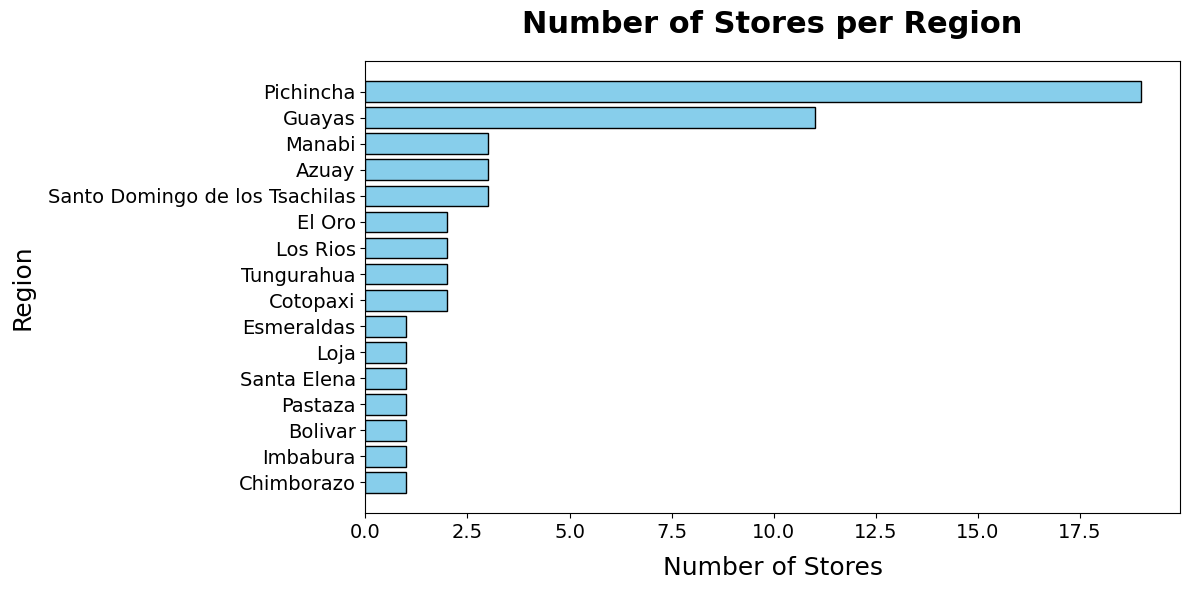

In [18]:
# Plotting the number of stores per region (state)
# Count the number of stores per region and sort in ascending order
stores_per_region = df_stores['state'].value_counts().reset_index()
stores_per_region.columns = ['Region', 'Store Count']
stores_per_region = stores_per_region.sort_values(by='Store Count', ascending=True)

# Plot the sorted data
plt.figure(figsize=(12, 6))  # Increase figure size for better readability
plt.barh(stores_per_region['Region'], stores_per_region['Store Count'], color='skyblue', edgecolor='black')  # Use horizontal bar plot
# Titles and labels with enhanced formatting
plt.title("Number of Stores per Region", fontsize=22, fontweight='bold', pad=20)
plt.xlabel("Number of Stores", fontsize=18, labelpad=10)
plt.ylabel("Region", fontsize=18, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

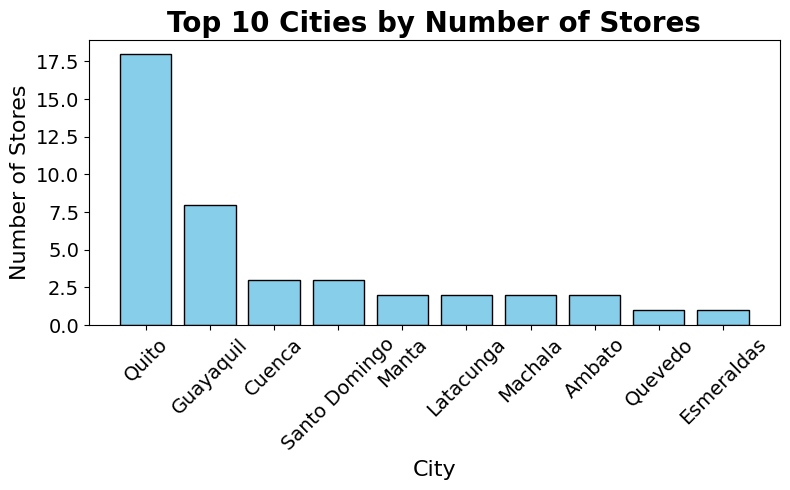

In [19]:
# Plotting the number of stores per city

# Compute the number of stores per city and select the top 10 cities
stores_per_city = df_stores['city'].value_counts().reset_index()
stores_per_city.columns = ['City', 'Store Count']
top_10_cities = stores_per_city.head(10)  # Keep only the top 10 cities

# Plot the top 10 cities
plt.figure(figsize=(8, 5))
plt.bar(top_10_cities['City'], top_10_cities['Store Count'], color='skyblue', edgecolor='black')
# Add titles and labels with appropriate formatting
plt.title("Top 10 Cities by Number of Stores", fontsize=20, fontweight='bold')
plt.xlabel("City", fontsize=16)
plt.ylabel("Number of Stores", fontsize=16)
# Adjust tick labels for better readability
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
# Ensure layout fits nicely
plt.tight_layout()
# Display the plot
plt.show()


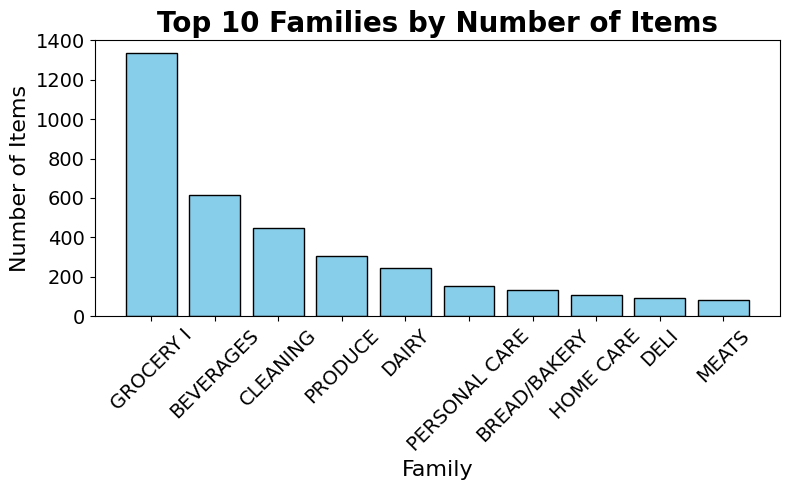

In [20]:
# Plotting the number of items per family (for top 10 families only)
# Compute the number of items per family and select the top 10 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_10_families = items_per_family.head(10)  # Keep only the top 10 families

# Plot the top 10 families
plt.figure(figsize=(8, 5))
plt.bar(top_10_families['Family'], top_10_families['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 10 Families by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

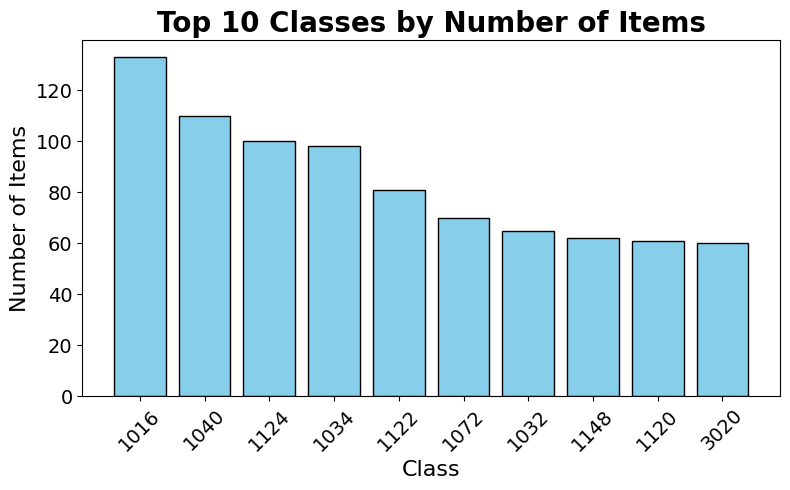

In [21]:
# Plotting the number of items per class
# Compute the number of items per class and select the top 10 classes
items_per_class = df_items['class'].value_counts().reset_index()
items_per_class.columns = ['Class', 'Item Count']
top_10_classes = items_per_class.head(10)  # Keep only the top 10 classes

# Plot the top 10 classes
plt.figure(figsize=(8, 5))
plt.bar(top_10_classes['Class'].astype(str), top_10_classes['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 10 Classes by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Class", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

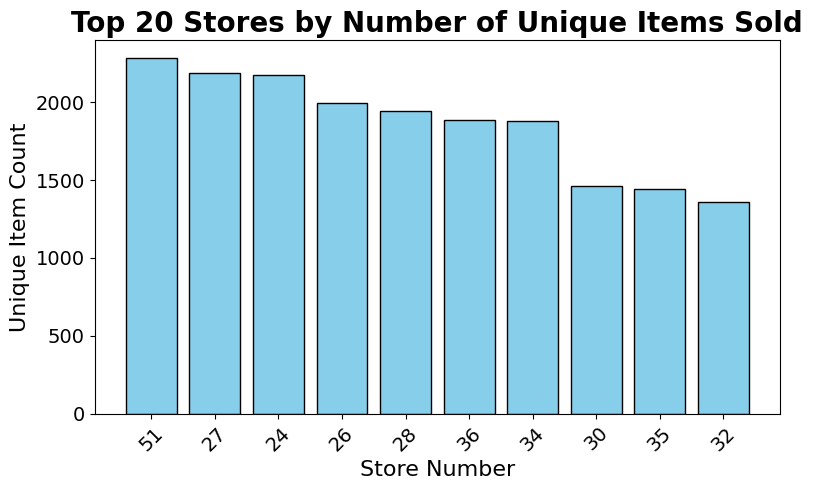

In [22]:
# Calculate the number of unique items per store in df_train
items_per_store = df_train.groupby('store_nbr')['item_nbr'].nunique().reset_index()
items_per_store.columns = ['Store Number', 'Unique Item Count']

# Select the top 10 stores by unique item count
top_20_stores = items_per_store.sort_values(by='Unique Item Count', ascending=False).head(20)
# Plot the top 10 stores
plt.figure(figsize=(8, 5))
plt.bar(top_20_stores['Store Number'].astype(str), top_20_stores['Unique Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 20 Stores by Number of Unique Items Sold", fontsize=20, fontweight='bold')
plt.xlabel("Store Number", fontsize=16)
plt.ylabel("Unique Item Count", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

## Sales Over Time (Aggregated)

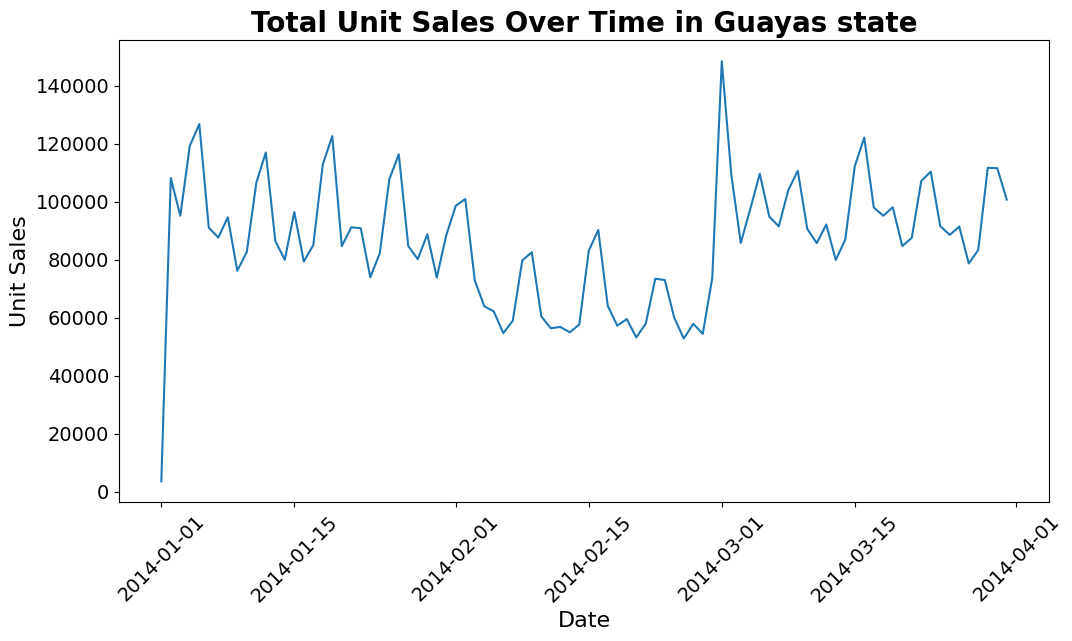

In [23]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

## Sales Trend by Year and Month

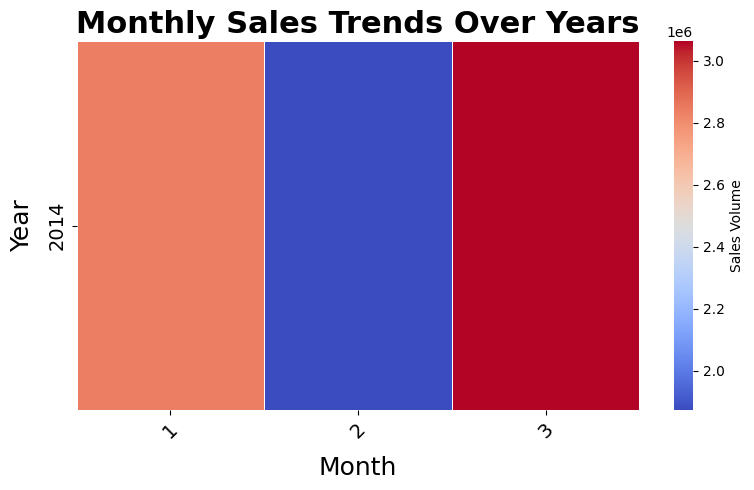

In [24]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Plotting heatmap of sales by year and month

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

## Number of new items launched every month

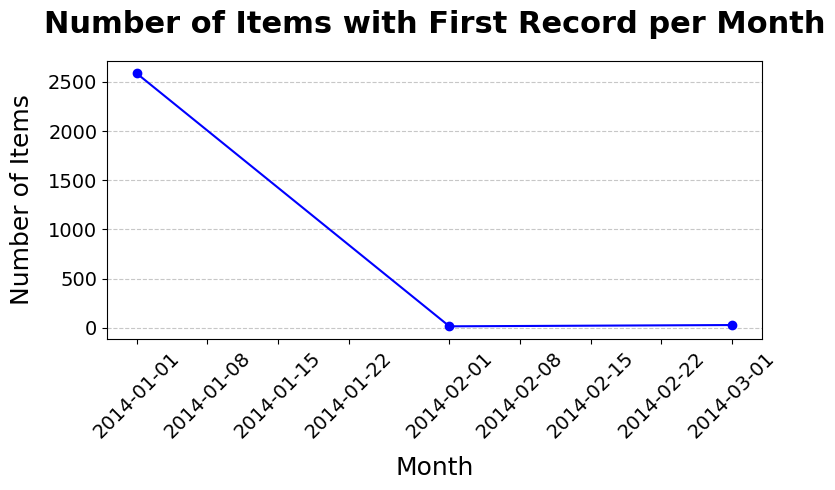

In [25]:
# Identify the first record for each item by date
df_train['date'] = pd.to_datetime(df_train['date'])  # Ensure the date column is in datetime format
first_record_per_item = df_train.groupby('item_nbr')['date'].min().reset_index()

# Extract year and month and count items for each month
first_record_per_item['YearMonth'] = first_record_per_item['date'].dt.to_period('M')
items_per_month = first_record_per_item['YearMonth'].value_counts().sort_index().reset_index()
items_per_month.columns = ['YearMonth', 'Item Count']

# Convert YearMonth back to datetime for plotting
items_per_month['YearMonth'] = items_per_month['YearMonth'].dt.to_timestamp()

# Plot the data
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(items_per_month['YearMonth'], items_per_month['Item Count'], marker='o', linestyle='-', color='b')  # Line plot with markers

# Add titles and labels
plt.title('Number of Items with First Record per Month', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Number of Items', fontsize=18, labelpad=10)

# Format the x-axis labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()


## Number of items discontinued every month

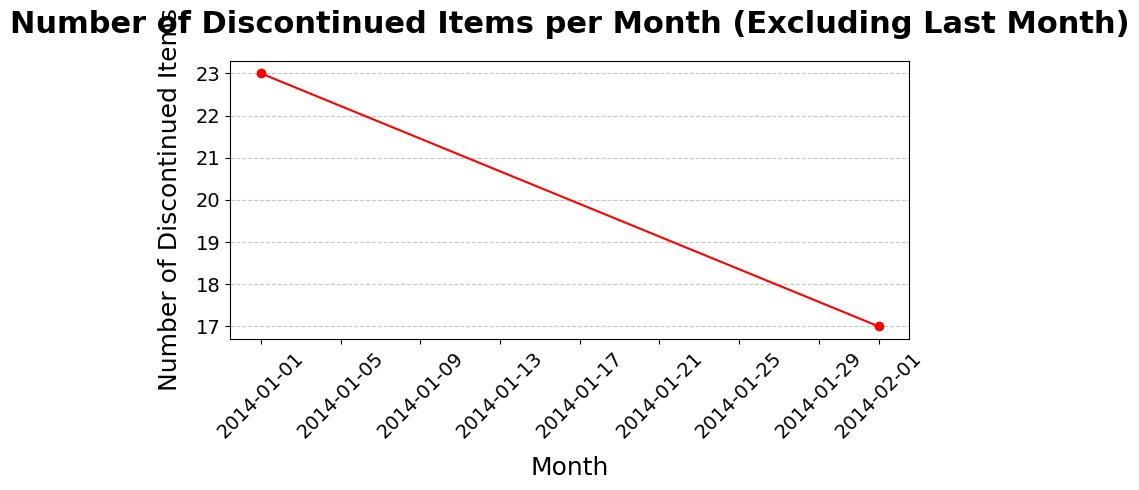

In [26]:
# Identify the last record for each item by date
df_train['date'] = pd.to_datetime(df_train['date'])  # Ensure the date column is in datetime format
last_record_per_item = df_train.groupby('item_nbr')['date'].max().reset_index()

# Extract year and month for each item's last record
last_record_per_item['YearMonth'] = last_record_per_item['date'].dt.to_period('M')

# Exclude the last month in the dataset
last_month = last_record_per_item['YearMonth'].max()
filtered_last_record_per_item = last_record_per_item[last_record_per_item['YearMonth'] != last_month]

# Count items discontinued per month (excluding the last month)
discontinued_items_per_month = filtered_last_record_per_item['YearMonth'].value_counts().sort_index().reset_index()
discontinued_items_per_month.columns = ['YearMonth', 'Item Count']

# Convert YearMonth back to datetime for plotting
discontinued_items_per_month['YearMonth'] = discontinued_items_per_month['YearMonth'].dt.to_timestamp()

# Plot the data
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(discontinued_items_per_month['YearMonth'], discontinued_items_per_month['Item Count'], marker='o', linestyle='-', color='r')  # Line plot with markers

# Add titles and labels
plt.title('Number of Discontinued Items per Month (Excluding Last Month)', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Number of Discontinued Items', fontsize=18, labelpad=10)

# Format the x-axis labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()

## Effect of Promotions on Sales

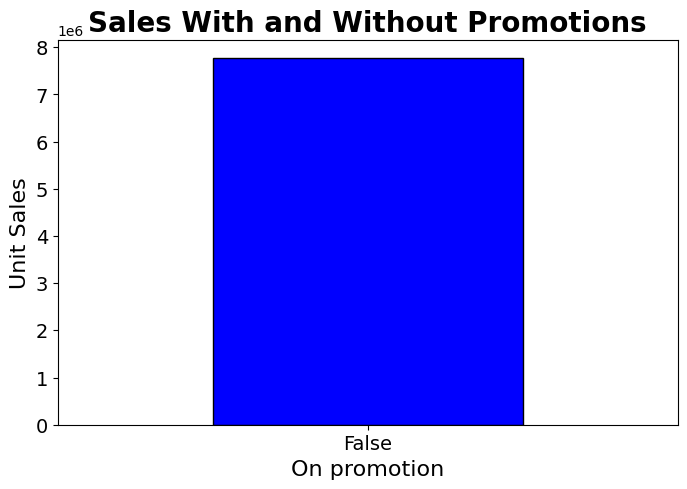

In [27]:
# Aggregating promotion and non-promotion sales
promo_sales = df_train.groupby('onpromotion')['unit_sales'].sum()

# Plotting
plt.figure(figsize=(8,5))
promo_sales.plot(kind='bar', color=['blue', 'orange'], edgecolor='black')
plt.title('Sales With and Without Promotions', fontsize=20, fontweight='bold')
plt.ylabel('Unit Sales', fontsize=16)
plt.xlabel('On promotion', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14)
plt.show()

# Investigating Relationship with Oil Prices

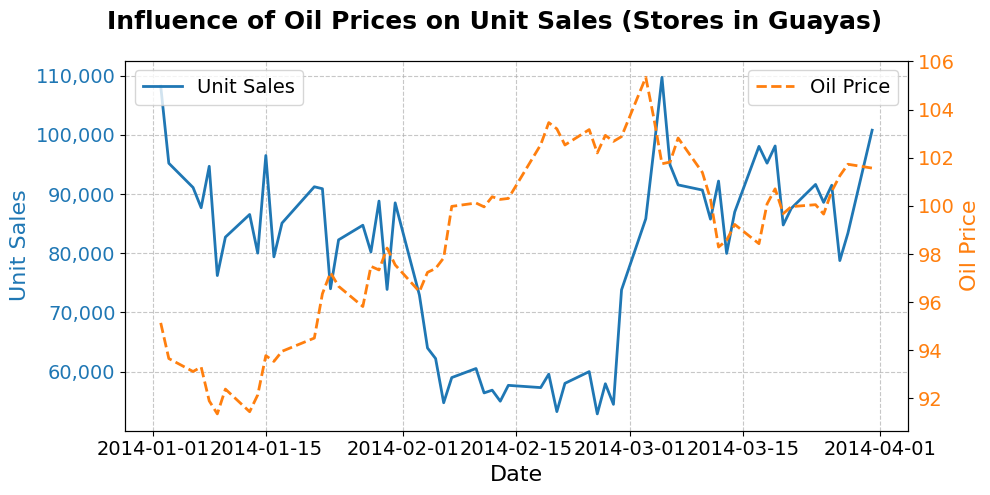

In [28]:
# Ensure datetime formats for merging and plotting
df_train['date'] = pd.to_datetime(df_train['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Aggregate sales data by date (using 'unit_sales')
sales_by_date = df_train.groupby('date')['unit_sales'].sum().reset_index()

# Merge aggregated sales with oil prices
merged_data = pd.merge(sales_by_date, df_oil, on='date', how='left')
del df_oil, sales_by_date  #clean up

# Rename columns for clarity
merged_data.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

# Drop rows where oil price is NaN
merged_data = merged_data.dropna(subset=['oil_price'])

# Plot unit sales and oil prices
fig, ax1 = plt.subplots(figsize=(10, 5))  # Bigger figure size for better readability

# Plot unit sales on the left y-axis
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Unit Sales', fontsize=16, color='tab:blue')
ax1.plot(merged_data['date'], merged_data['unit_sales'], label='Unit Sales', color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Format y-axis for unit sales
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Plot oil prices on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price', fontsize=16, color='tab:orange')
ax2.plot(merged_data['date'], merged_data['oil_price'], label='Oil Price', color='tab:orange', linewidth=2, linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=14)

# Add grid, titles, and legends
fig.suptitle('Influence of Oil Prices on Unit Sales (Stores in Guayas)', fontsize=18, fontweight='bold')
ax1.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper right', fontsize=14)
ax1.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

In total sales where is very no direct influence of oil prices visible.

# Examining the Impact of Holidays

Holidays range: from 2012-03-02 till 2017-12-26


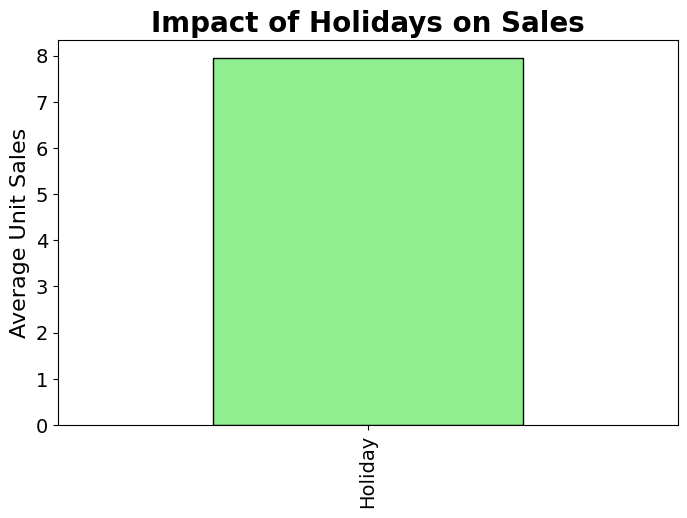

In [29]:
# Convert date column to datetime
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print("Holidays range: from",df_holidays_events['date'].dt.date.min(),"till",df_holidays_events['date'].dt.date.max())

# Merging df_train data with holidays
df_train_holiday = pd.merge(df_train, df_holidays_events, on='date', how='left')

# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Analyzing Perishable Items

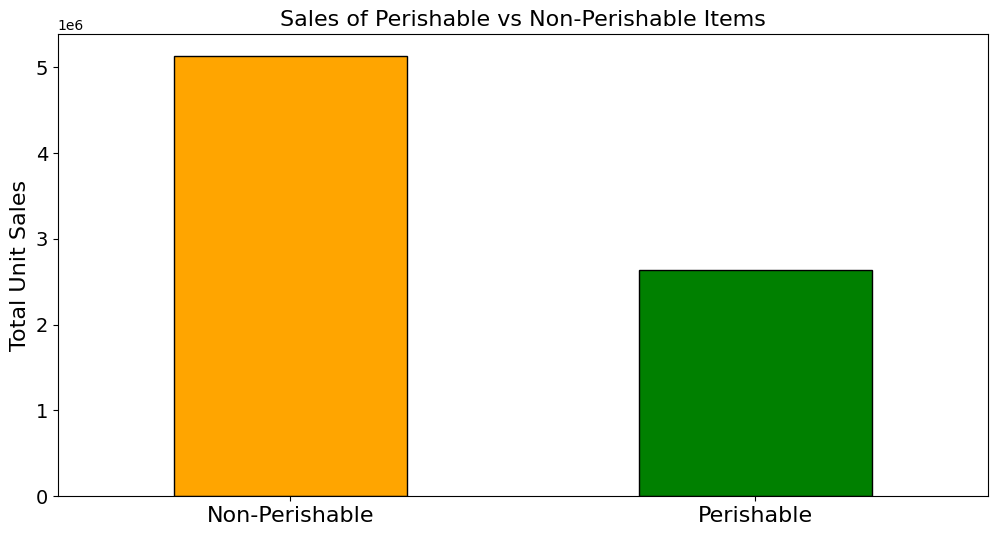

In [30]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(12,6))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()

# Fill out missing dates with 0 sales

In [31]:
# As an example we will show how to add 0 sales only on part of the dataset
# In your project you should do the operation on the whole df_train dataset
#df_train_sample = df_train.sample(1000)

In [32]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.date_range(start=min_date, end=max_date, freq='D').to_frame(index=False, name='date')

# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')

# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

# Check the first few rows
print(df_filled.head())
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')

# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

# Check the first few rows
print(df_filled.head())

   store_nbr  item_nbr       date          id  unit_sales onpromotion    year  \
0         36     96995 2014-01-01  16323658.0         1.0       False  2014.0   
1         36     96995 2014-01-02  16365887.0         7.0       False  2014.0   
2         36     96995 2014-01-03         NaN         0.0         NaN     NaN   
3         36     96995 2014-01-04  16499179.0         2.0       False  2014.0   
4         36     96995 2014-01-05  16567119.0         1.0       False  2014.0   

   month  day  day_of_week  unit_sales_7d_avg  
0    1.0  1.0          2.0                NaN  
1    1.0  2.0          3.0                NaN  
2    NaN  NaN          NaN                NaN  
3    1.0  4.0          5.0                NaN  
4    1.0  5.0          6.0                NaN  
   store_nbr  item_nbr       date          id  unit_sales onpromotion    year  \
0         36     96995 2014-01-01  16323658.0         1.0       False  2014.0   
1         36     96995 2014-01-02  16365887.0         7.0      

In [33]:
# intial dataframe didn't have rows with 0 sales
df_train[df_train['unit_sales'] ==0]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
10834,16366453,2014-01-02,36,812769,0.0,False,2014,1,2,3,NaN
36271,16523001,2014-01-04,51,205209,0.0,False,2014,1,4,5,NaN
89111,16812790,2014-01-09,27,1464034,0.0,False,2014,1,9,3,6.000000
94957,16820878,2014-01-09,36,1124165,0.0,False,2014,1,9,3,1.857143
95598,16841624,2014-01-09,51,374464,0.0,False,2014,1,9,3,4.571429
...,...,...,...,...,...,...,...,...,...,...,...
972311,21553947,2014-03-30,24,1372566,0.0,False,2014,3,30,6,3.285714
979858,21565145,2014-03-30,34,1463825,0.0,False,2014,3,30,6,5.142857
995552,21656156,2014-03-31,51,1146785,0.0,False,2014,3,31,0,3.285714
995553,21656157,2014-03-31,51,1146786,0.0,False,2014,3,31,0,2.857143


In [34]:
# now we have many rows with 0 sales
df_filled[df_filled['unit_sales'] ==0]

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
2,36,96995,2014-01-03,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6,36,96995,2014-01-07,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,36,96995,2014-01-08,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11,36,96995,2014-01-12,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
12,36,96995,2014-01-13,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1675074,51,1279049,2014-03-26,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1675075,51,1279049,2014-03-27,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1675076,51,1279049,2014-03-28,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1675077,51,1279049,2014-03-29,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


**ARIMA**

In [35]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 972.2/972.2 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00


In [36]:
import pandas as pd
from darts import TimeSeries

In [37]:
df_filled['date'] = pd.to_datetime(df_filled['date'])

# Group by date and aggregate sales for each day
df_filtered = df_filled.groupby('date').sum()['unit_sales'].reset_index()

# Setting an index after the aggregation made
df_filtered.set_index('date', inplace=True)

# Fill missing dates with zero sales (since some dates may have no sales)
df_filtered = df_filtered.asfreq('D').fillna(0)

# Convert to a Darts TimeSeries object
series = TimeSeries.from_dataframe(df_filtered, value_cols='unit_sales')

In [38]:
# Split the data (80% training, 20% testing)
train, test = series.split_after(0.8)

In [39]:
from darts.models import ARIMA

# Initialize ARIMA model with (p, d, q) parameters
arima_model = ARIMA(p=5, d=1, q=0)

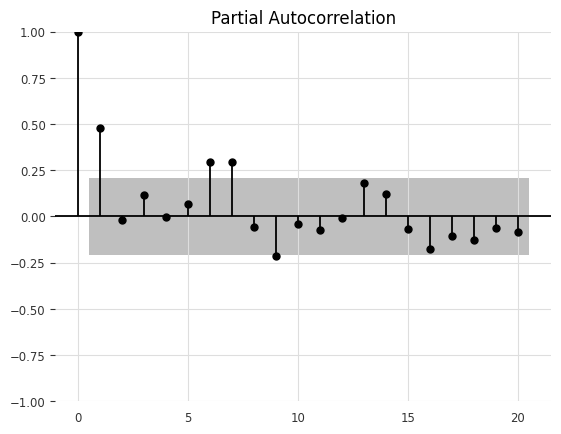

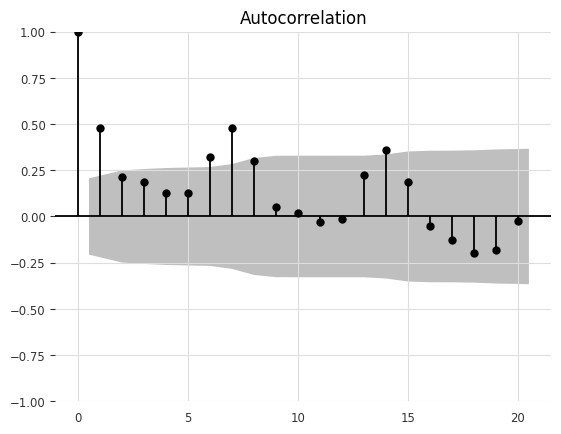

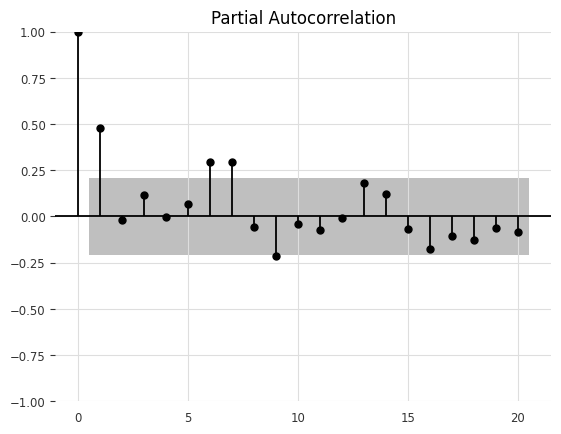

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_filtered['unit_sales'], lags=20)
plot_pacf(df_filtered['unit_sales'], lags=20)

<Axes: xlabel='date'>

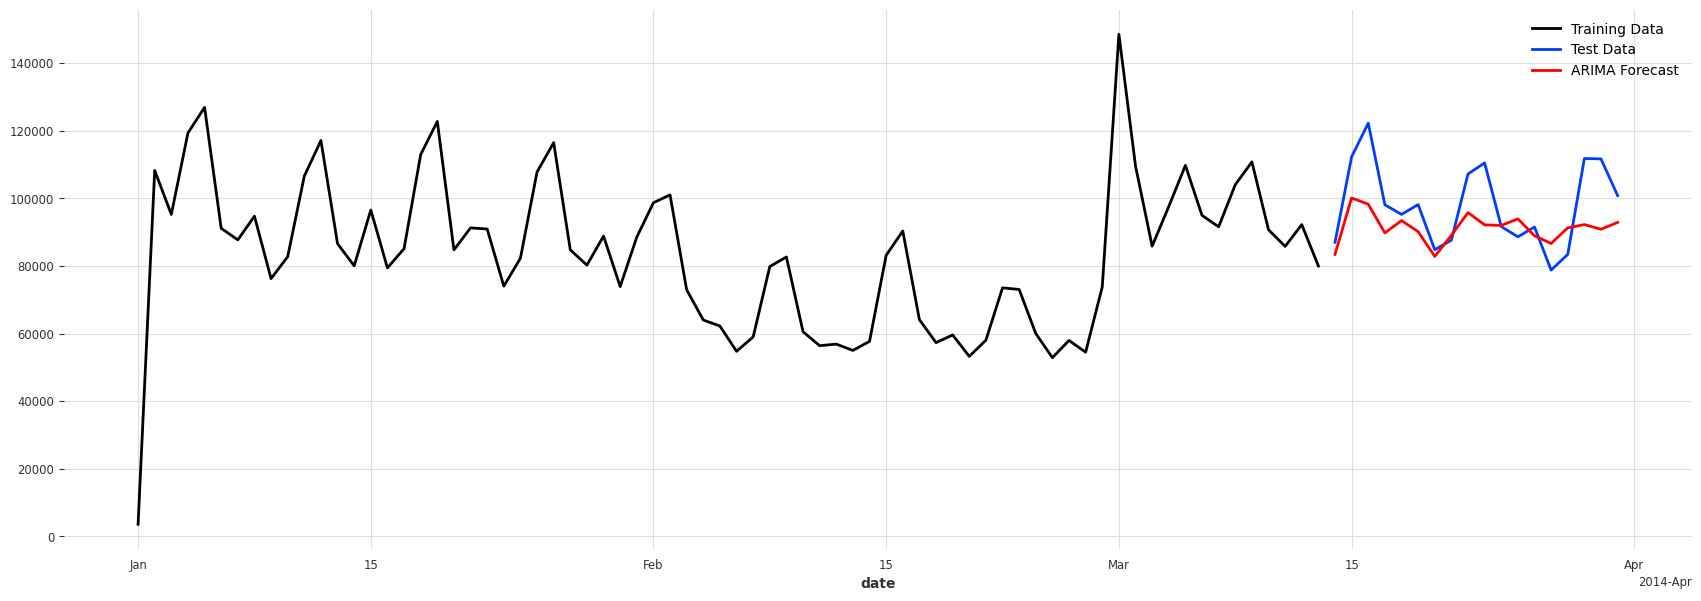

In [41]:
# Fit the ARIMA model on the training data
arima_model.fit(train)

# Forecast the next values (the same length as the test set)
arima_forecast = arima_model.predict(len(test))

# Plot ARIMA forecast vs actual data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train.plot(label='Training Data')
test.plot(label='Test Data')
arima_forecast.plot(label='ARIMA Forecast', color='red')

**SARIMA**

In [42]:
!pip install --upgrade darts


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<Axes: xlabel='date'>

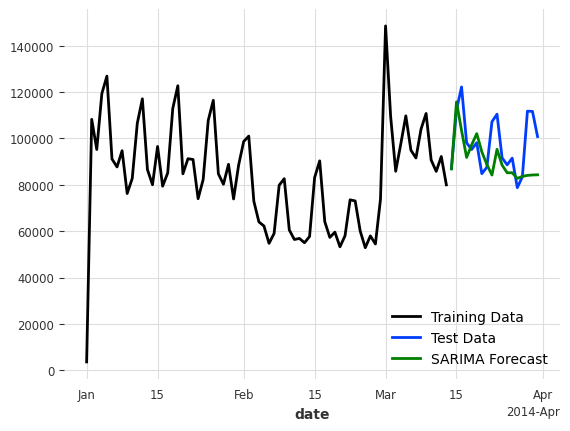

In [43]:
from darts.models import AutoARIMA

sarima_model = AutoARIMA(seasonal=True, m=7)  # Weekly seasonality
sarima_model.fit(train)

# Forecast for the test set
sarima_forecast = sarima_model.predict(len(test))

# Plot SARIMA results against the actual test data
train.plot(label='Training Data')
test.plot(label='Test Data')
sarima_forecast.plot(label='SARIMA Forecast', color='green')

**LSTM Network**

In [44]:
#Preparing the Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

**Preprocessing the data for LSTM**

In [45]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_filled['unit_sales'] = scaler.fit_transform(df_filled[['unit_sales']])

In [46]:
# Create sequences of data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [47]:
# Set sequence length (e.g., past 30 days of sales)
seq_length = 30

# Create sequences
data = df_filled['unit_sales'].values
X, y = create_sequences(data, seq_length)

In [48]:
# Split into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data to be [samples, time steps, features] for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

**Building and Training the LSTM Model**

In [49]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

20939/20939 ━━━━━━━━━━━━━━━━━━━━ 856s 41ms/step - loss: 1.7828e-05 - val_loss: 2.9103e-06


**Making Predictions and Evaluating the Model**

10470/10470 ━━━━━━━━━━━━━━━━━━━━ 90s 9ms/step


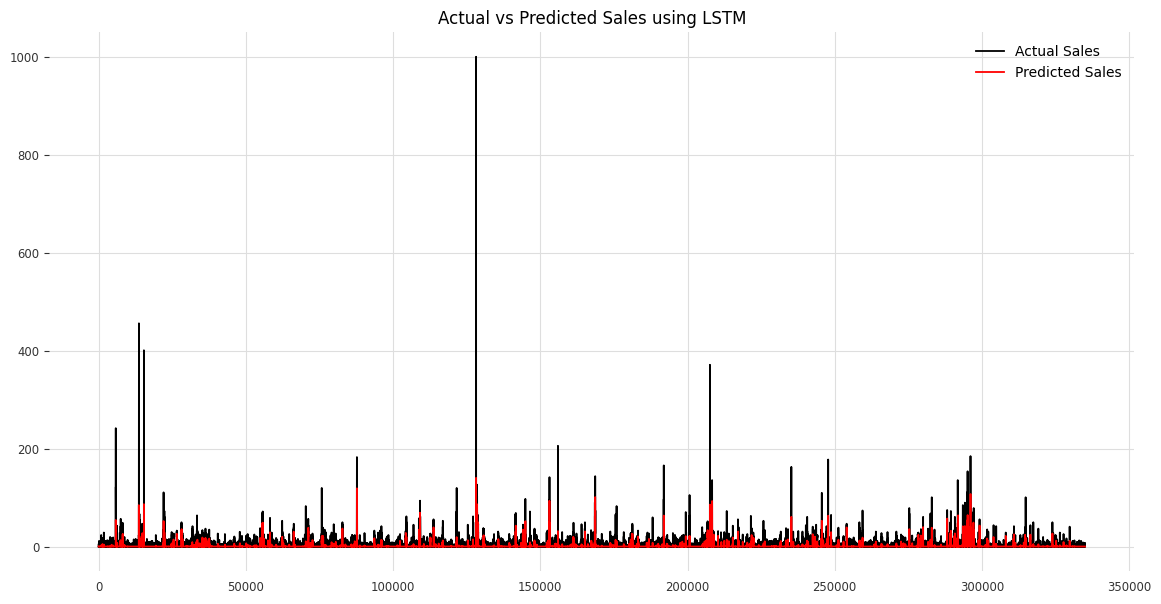

In [51]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()

**Hyperparameter Tuning for XGBoost**

In [52]:
# Reshape X_train to 2D for XGBoost
X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1])

# Fit the model and search for the best hyperparameters
#random_search.fit(X_train_2d, y_train) # Use the reshaped data here

In [54]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

# Prepare data with lagged features and rolling statistics
xgb = XGBRegressor(objective='reg:squarederror')

# Define the parameter grid, trying 3 values for each parameter
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgb,
																	 param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error')

# Fit the model and search for the best hyperparameters
random_search.fit(X_train_2d, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)


Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'eta': 0.1, 'colsample_bytree': 0.7}


**Hyperparameter Tuning for LSTM**

In [55]:
!pip install scikeras

In [58]:
!pip install --upgrade scikit-learn

In [62]:
from tensorflow.keras.optimizers import Adam


In [63]:
def build_lstm_model(units=50, dropout_rate=0.2, learning_rate=0.01):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        Dropout(dropout_rate),
        LSTM(units),
        Dropout(dropout_rate),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [65]:
best_loss = float("inf")
best_params = {}

for units in [50, 100]:
    for dropout_rate in [0.2, 0.3]:
        for learning_rate in [0.001, 0.01]:
            print(f"Training LSTM with units={units}, dropout={dropout_rate}, lr={learning_rate}")
            model = build_lstm_model(units, dropout_rate, learning_rate)
            model.fit(X_train_scaled, y_train, epochs=10, batch_size=16, verbose=0)

            loss = model.evaluate(X_test_scaled, y_test, verbose=0)
            print(f"Validation Loss: {loss}")

            if loss < best_loss:
                best_loss = loss
                best_params = {'units': units, 'dropout': dropout_rate, 'lr': learning_rate}

print("Best Hyperparameters:", best_params)


Training LSTM with units=50, dropout=0.2, lr=0.001


KeyboardInterrupt: 

**Log metrics for XGBoost model in MLFlow**

In [72]:
#Split in test and train datasets
split_date = '2014-03-01'
train = df_filled[df_filled['date'] < split_date]
test = df_filled[df_filled['date'] >= split_date]
print("Train dataframe shape:",train.shape)
print("Test dataframe shape:",test.shape)

Train dataframe shape: (1098108, 11)
Test dataframe shape: (576972, 11)


In [77]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

# Convert 'onpromotion' to bool before training
X_train['onpromotion'] = X_train['onpromotion'].astype(bool)  # Convert to bool
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

X_test['onpromotion'] = X_test['onpromotion'].astype(bool)  # Convert to bool
y_test = test['unit_sales']

In [78]:
import xgboost as xgb

In [79]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, enable_categorical=True)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

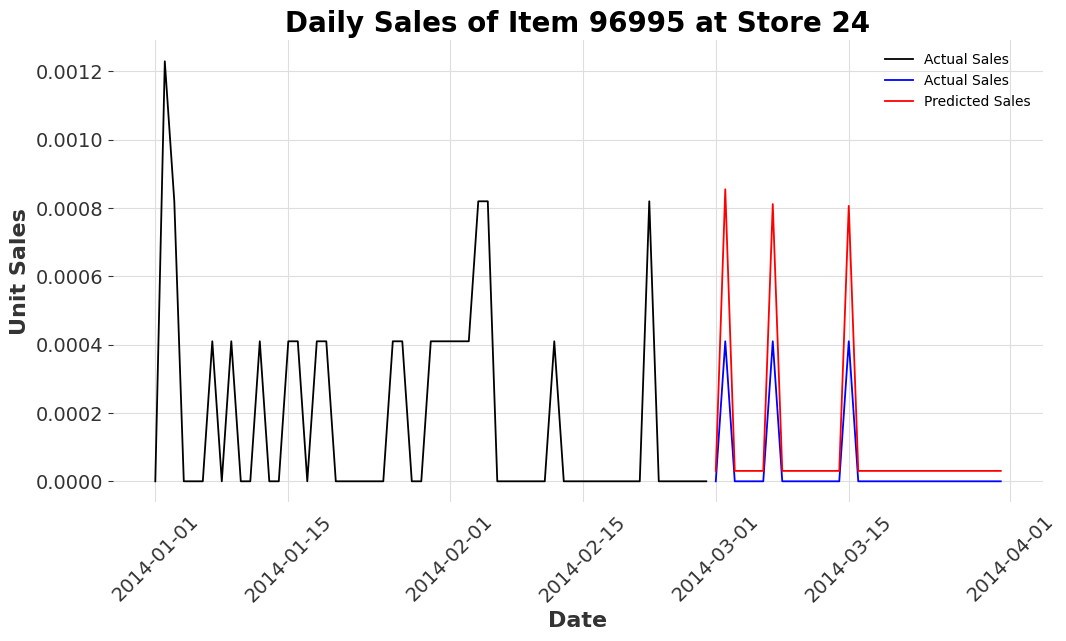

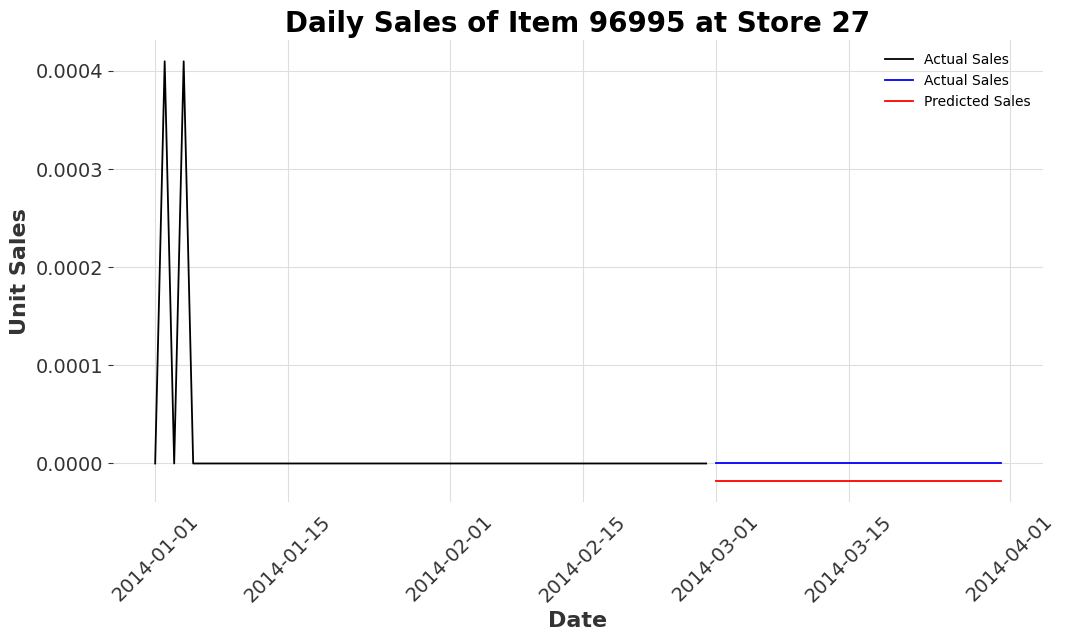

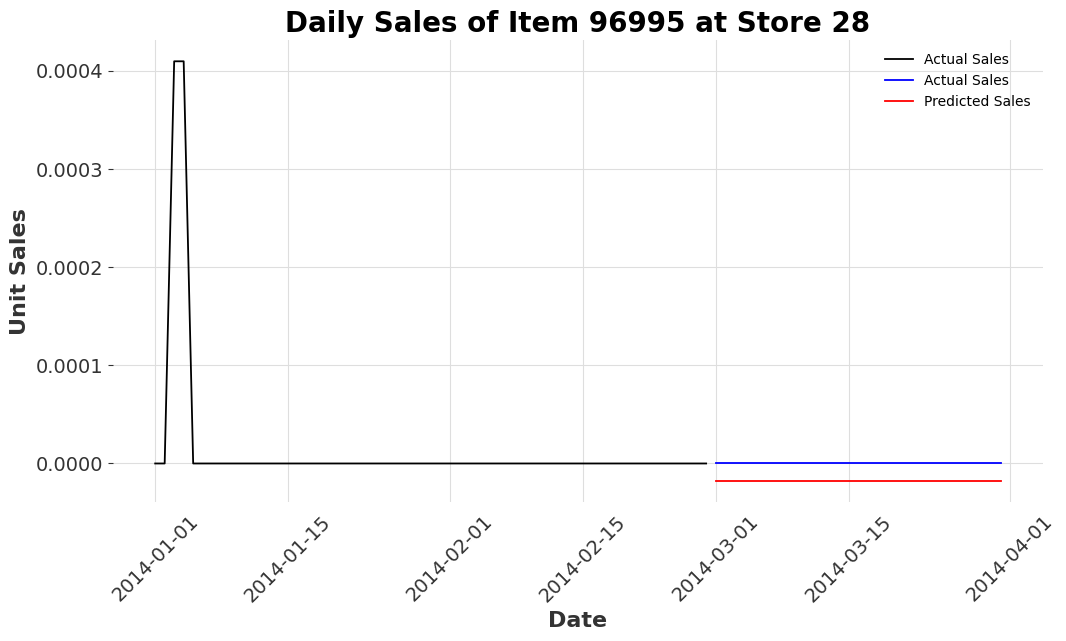

In [81]:
# Calculate metrics values and Plot the actual vs predicted values
rmad_values = []
bias_values = []
rmse_values = []
plot_paths = []
plot_count  = 0
for (item_nbr, store_nbr), group in df_filled.groupby(['item_nbr', 'store_nbr']):
  #group = group.groupby(['date']).sum()['unit_sales'].reset_index()
  test_series = group[group['date'] >= split_date]
  if(len(test_series)>10):
    X_test = test_series.drop('unit_sales', axis=1)
    X_test = X_test.drop('date', axis=1)

    # Explicitly convert 'onpromotion' to bool before prediction
    X_test['onpromotion'] = X_test['onpromotion'].astype(bool)

    y_test = test_series['unit_sales']
    # Make predictions on the test set
    y_pred = xgboost_model.predict(X_test)

    if plot_count<3:
      train_series = group[group['date'] < split_date]
      plt.figure(figsize=(12, 6))
      plt.plot(train_series['date'], train_series['unit_sales'].values, label='Actual Sales', color='black')
      plt.plot(test_series['date'], y_test.values, label='Actual Sales', color='blue')
      plt.plot(test_series['date'], y_pred, label='Predicted Sales', color='red')
      plt.title(f'Daily Sales of Item {item_nbr} at Store {store_nbr}', fontsize=20, fontweight='bold')
      plt.xlabel('Date', fontsize=16)
      plt.ylabel('Unit Sales', fontsize=16)
      plt.xticks(fontsize=14, rotation=45)
      plt.yticks(fontsize=14)
      file_path = f'XGBoost_forecast_store_{store_nbr}_item_{item_nbr}.png'
      plt.legend()
      plt.savefig(file_path)  # Saves the plot as a PNG file
      plt.show()
      plot_paths.append(file_path)
      plot_count = plot_count + 1

    #Calculate metric values for XGBoost model
    # Bias calculation: mean of the residuals (y_pred - y_test)
    bias = np.mean(y_pred - y_test)
    bias_values.append(bias)
    # Root Mean Absolute Deviation (RMAD)
    rmad = np.mean(np.abs(y_pred - y_test))
    rmad_values.append(rmad)
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

In [67]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.7/648.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.3 MB/s eta 0:00:00


In [83]:
import mlflow.xgboost
from mlflow.models.signature import infer_signature # Import the infer_signature function

with mlflow.start_run(run_name="XGBoost_store_item_features_run"):
    run_id = mlflow.active_run().info.run_id
    print(f"Run ID: {run_id}")
    mlflow.log_param("objective", "reg:squarederror") #value we used above
    mlflow.log_param("n_estimators", 100) #value we used above
    mlflow.log_param("max_depth", 5) #value we used above
    mlflow.log_param("learning_rate", 0.1) #value we used above
    mlflow.log_metric("rMAD", sum(rmad_values)/len(rmad_values)) #average rMAD
    mlflow.log_metric("Bias", sum(bias_values)/len(bias_values)) #average Bias
    mlflow.log_metric("RMSE", sum(rmse_values)/len(rmse_values)) #average RMSE
    for plot_path in plot_paths:
      mlflow.log_artifact(plot_path, artifact_path="plots")
    # Log the XGBoost model
    ## Example data (replace with a sample from your dataset)
    #input_example = X_train[:5]
    # Infer signature from input and output data
    signature = infer_signature(X_train, xgboost_model.predict(X_train))
    #print(signature)
    #mlflow.sklearn.log_model(xgboost_model, "xgboost_model",
    #                         signature=signature)
    mlflow.xgboost.log_model(xgboost_model, "xgboost_model",
                             signature=signature)
    # Optionally log parameters, metrics, etc.
    mlflow.log_params(xgboost_model.get_params())
    mlflow.log_metric("train_score", xgboost_model.score(X_train, y_train))

Run ID: 3a9e1e538ef44f7d806427364a2fc970


/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose bet

In [ ]:
#Save Pickle file

In [85]:
logged_model = 'runs:/3a9e1e538ef44f7d806427364a2fc970/xgboost_model'  # Replace with the correct Run ID

# Load model as xgboost model
loaded_model = mlflow.xgboost.load_model(logged_model)
print("=== Model type", type(loaded_model))

=== Model type <class 'xgboost.sklearn.XGBRegressor'>


In [86]:
# create the path to store pickle files of the models
!mkdir /content/drive/MyDrive/models/

In [87]:
import pickle
# Save the model as a pickle file in Google Drive
pickle_path = '/content/drive/MyDrive/models/xgboost_model.pkl'  # Adjust Google Drive path as desired

with open(pickle_path, 'wb') as f:
    pickle.dump(loaded_model, f)

print(f"Model saved as pickle file at: {pickle_path}")

Model saved as pickle file at: /content/drive/MyDrive/models/xgboost_model.pkl


In [88]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


In [89]:
import streamlit as st

In [90]:
st.title("My First Streamlit App 🎈")
st.write("Hello, this is a simple test app!")

2025-03-07 14:37:44.299 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-07 14:37:46.131 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-07 14:37:46.135 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-07 14:37:46.139 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-07 14:37:46.140 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-07 14:37:46.145 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-07 14:37:46.154 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [92]:
pip install streamlit

In [94]:
streamlit run app.py


SyntaxError: invalid syntax (<ipython-input-94-718866ff34b9>, line 1)